In [1]:
%load_ext autoreload
%autoreload 2

# TransducedLM vs FusedTransducedLM Benchmark (BPE)

Compares two approaches to computing next-byte log-probabilities through
a BPE FST (maps GPT-2 token IDs → bytes):

- **TransducedLM**: two-phase (PeekabooState BFS decomposition, then LM-weighted search)
- **FusedTransducedLM**: single-pass (interleaved decomposition + LM search, no separate BFS)

Uses a 3-gram CharNgramLM over token IDs as the inner LM, with per-call
timeouts and a process-wide memory limit.

The BPE FST has a star topology: each token maps to its byte spelling via
a chain of epsilon-input arcs, then a single token-consuming arc back to
the start state. This creates a very different decomposition structure
from the PTB tokenizer (which has complex rewrite rules and 296 states).

In [ ]:
import time, gc
import numpy as np
from matplotlib import pyplot as plt
from transformers import AutoTokenizer
from transduction.applications.bpe import bpe_wfst
from transduction.fst import FST
from transduction.fsa import EPSILON
from transduction.lm.statelm import decode_hf_tokenizer
from transduction.util import Timeout, timelimit, set_memory_limit
from transduction.position_set_peekaboo import PositionSetPeekabooState, _PositionSetPeekabooUniv
set_memory_limit(8)

In [3]:
# ---- Tunable parameters ----
VOCAB_SIZE = None    # None → only tokens from training data (~43)
                     # int  → use that many from GPT-2 vocab (max ~50k)

In [14]:
tokenizer = AutoTokenizer.from_pretrained('gpt2', use_fast=False)
_, _, _decode, _ = decode_hf_tokenizer(tokenizer)
drop = {x.encode() for x in tokenizer.all_special_tokens}

# All non-special token IDs available
all_token_ids = sorted(i for i in range(len(_decode)) if _decode[i] not in drop)

# Training data for the inner n-gram LM
train_sentences = [
    "The quick brown fox jumps over the lazy dog.",
    "A stitch in time saves nine.",
    "To be or not to be, that is the question.",
    "All that glitters is not gold.",
    "Actions speak louder than words.",
    "Practice makes perfect.",
    "Where there is a will, there is a way.",
] * 3

train_ids = [tokenizer.encode(s) for s in train_sentences]
train_used = sorted(set(tid for seq in train_ids for tid in seq))

# Select vocabulary subset
if VOCAB_SIZE is None:
    used_ids = train_used
else:
    used_ids = all_token_ids[:VOCAB_SIZE]
    # Always include training tokens so n-gram LM has valid data
    used_ids = sorted(set(used_ids) | set(train_used))

print(f'Training tokens: {len(train_used)}, Selected vocab: {len(used_ids)} / {len(all_token_ids)} total')

# Build subsampled BPE FST
def subsampled_bpe_fst(decode, token_ids, drop=frozenset()):
    """Build a BPE FST from a subset of token IDs."""
    m = FST()
    m.add_start(())
    for i in token_ids:
        x = decode[i]
        if x in drop:
            continue
        bx = tuple(x)
        for j in range(len(bx)):
            m.add_arc(bx[:j], EPSILON, bx[j], bx[:j+1])
        m.add_arc(bx, i, EPSILON, ())
    m.add_stop(())
    return m

t0 = time.perf_counter()
bpe_fst = subsampled_bpe_fst(_decode, used_ids, drop)
print(f'BPE FST built in {time.perf_counter()-t0:.3f}s: '
      f'{len(bpe_fst.states)} states, |A|={len(bpe_fst.A)}, |B|={len(bpe_fst.B)}')

Training tokens: 43, Selected vocab: 43 / 50256 total
BPE FST built in 0.000s: 140 states, |A|=44, |B|=34


In [15]:
# Generate target byte sequence by transducing token IDs through the FST
text = "The quick brown fox jumps over the lazy dog."
token_ids_test = tokenizer.encode(text)
target_seq = list(bpe_fst.transduce(token_ids_test))
print(f'Text: {text!r}')
print(f'Token IDs: {token_ids_test}')
print(f'Target (bytes): {len(target_seq)} symbols')
print(f'Decoded: {bytes(target_seq).decode()!r}')

# Train inner LM on token-ID sequences
from transduction.lm.ngram import CharNgramLM
source_alpha = bpe_fst.A - {EPSILON}
inner_lm = CharNgramLM.train(train_ids, n=3, alpha=0.5, alphabet=source_alpha)
print(f'Inner LM: alphabet={len(inner_lm.alphabet)} symbols')

Text: 'The quick brown fox jumps over the lazy dog.'
Token IDs: [464, 2068, 7586, 21831, 18045, 625, 262, 16931, 3290, 13]
Target (bytes): 44 symbols
Decoded: 'The quick brown fox jumps over the lazy dog.'
Inner LM: alphabet=44 symbols


## Decomposition Backend Comparison

Benchmark the raw decomposition step (building Q/R for a target prefix)
across backends:

- **NonrecursiveDFADecomp** — pure-Python powerset + universality
- **PyniniNonrecursiveDecomp** — pynini/OpenFST composition backend
- **RustDecomp** — Rust-accelerated powerset + universality

Each method is called fresh on the same target prefixes at increasing
lengths. Times are best-of-3 to reduce noise.

In [16]:
from transduction.dfa_decomp_nonrecursive import NonrecursiveDFADecomp
from transduction.pynini_ops import PyniniNonrecursiveDecomp, PyniniPrecover
from transduction.rust_bridge import RustDecomp

# Pre-init pynini backend (amortizes FST conversion across targets)
pynini_backend = PyniniPrecover(bpe_fst)

prefix_lengths = [l for l in [3, 5, 8, 10, 15, 20, 30, 40]
                  if l <= len(target_seq)]

methods = [
    ('Standard',  lambda t: NonrecursiveDFADecomp(bpe_fst, t)),
    ('Pynini',    lambda t: PyniniNonrecursiveDecomp(bpe_fst, t, backend=pynini_backend)),
    ('Rust',      lambda t: RustDecomp(bpe_fst, t)),
]

decomp_results = {name: [] for name, _ in methods}

print(f'BPE FST: {len(bpe_fst.states)} states, |A|={len(bpe_fst.A)}, |B|={len(bpe_fst.B)}')
print(f'{"len":>5s}', end='')
for name, _ in methods:
    print(f'  {name:>12s}', end='')
print()
print('-' * (5 + 14 * len(methods)))

for length in prefix_lengths:
    target = tuple(target_seq[:length])
    print(f'{length:5d}', end='')
    for name, fn in methods:
        times = []
        for _ in range(3):
            t0 = time.perf_counter()
            d = fn(target)
            _ = d.quotient
            _ = d.remainder
            times.append(time.perf_counter() - t0)
        best = min(times)
        decomp_results[name].append(best)
        print(f'  {best*1000:10.1f}ms', end='')
    print()

# Summary
std_times = decomp_results['Standard']
print(f'\nSpeedup vs Standard (geomean):')
from math import exp, log
for name in decomp_results:
    if name == 'Standard':
        continue
    ratios = [s / o for s, o in zip(std_times, decomp_results[name]) if o > 0]
    if ratios:
        geo = exp(sum(log(r) for r in ratios) / len(ratios))
        print(f'  {name}: {geo:.1f}x')

BPE FST: 140 states, |A|=44, |B|=34
  len      Standard        Pynini          Rust
-----------------------------------------------
    3         3.8ms         0.1ms         1.0ms
    5         3.7ms         0.2ms         1.5ms
    8         3.3ms         0.1ms         0.8ms
   10         5.2ms         0.1ms         0.9ms
   15         3.6ms         0.1ms         0.8ms
   20         5.7ms         0.1ms         0.9ms
   30         4.6ms         0.1ms         0.9ms
   40         6.8ms         0.2ms         0.9ms

Speedup vs Standard (geomean):
  Pynini: 41.1x
  Rust: 4.7x


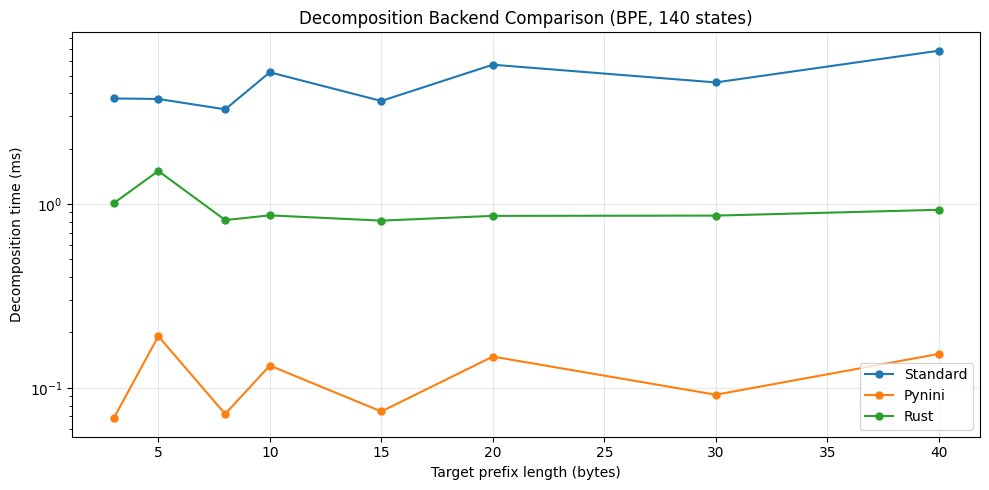

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))
for name in decomp_results:
    ax.plot(prefix_lengths, [t * 1000 for t in decomp_results[name]],
            'o-', label=name, markersize=5)
ax.set_xlabel('Target prefix length (bytes)')
ax.set_ylabel('Decomposition time (ms)')
ax.set_title(f'Decomposition Backend Comparison (BPE, {len(bpe_fst.states)} states)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
plt.tight_layout()
plt.show()

## Decomposition Backend Comparison

Raw decomposition speed on the BPE FST at various target prefix lengths.
Compares:
- **Standard** (NonrecursiveDFADecomp): Python powerset determinization + universality
- **Pynini**: OpenFST composition backend (PyniniNonrecursiveDecomp)
- **Rust**: Rust-accelerated decomposition (RustDecomp)

## TransducedLM Scaling

Per-step decode time for **TransducedLM** (two-phase: PeekabooState BFS
decomposition, then LM-weighted search) vs **FusedTransducedLM** (single-pass:
interleaved decomposition + LM search, no separate BFS).

Each step includes both decomposition and LM search costs. Both use
`K=20`, `max_expansions=200`, with a 3s timeout per step.

In [ ]:
from collections import defaultdict
from transduction.lm.transduced import TransducedLM
from transduction.lm.fused_transduced import FusedTransducedLM
from transduction.lm.pynini_transduced import PyniniTransducedLM

MAX_DECODE = 100             # number of decode steps
MAX_SEARCH = 200             # max priority-queue steps per logp_next
MAX_BEAM = 10                # max items carried forward
LM_TIMEOUT = 30               # seconds per step

lm_results = defaultdict(list)  # name -> [(step, time_s, logp)]

configs = [
    ('TransducedLM', lambda: TransducedLM(
        inner_lm, bpe_fst, K=MAX_BEAM, max_expansions=MAX_SEARCH)),
    ('TransducedLM (PosSet)', lambda: TransducedLM(
        inner_lm, bpe_fst, K=MAX_BEAM, max_expansions=MAX_SEARCH,
        decomp_state_cls=PositionSetPeekabooState,
        univ_cls=_PositionSetPeekabooUniv)),
    ('FusedTransducedLM', lambda: FusedTransducedLM(
        inner_lm, bpe_fst, max_steps=MAX_SEARCH, max_beam=MAX_BEAM)),
    ('PyniniTransducedLM', lambda: PyniniTransducedLM(
        inner_lm, bpe_fst, K=MAX_BEAM, max_expansions=MAX_SEARCH)),
]

for name, make_tlm in configs:
    print(f'\n{name} (K={MAX_BEAM}, max_expansions={MAX_SEARCH}):')
    try:
        with timelimit(LM_TIMEOUT):
            tlm = make_tlm()
            state = tlm.initial()
    except (Timeout, MemoryError, ValueError) as e:
        print(f'  initial() failed: {type(e).__name__}: {e}')
        continue
    for i in range(min(MAX_DECODE, len(target_seq))):
        y = target_seq[i]
        try:
            with timelimit(LM_TIMEOUT):
                t0 = time.perf_counter()
                lp = state.logp_next[y]
                state = state >> y
                t1 = time.perf_counter()
        except Timeout:
            print(f'  step {i+1} TIMEOUT ({LM_TIMEOUT}s)')
            break
        except MemoryError:
            print(f'  step {i+1} OOM')
            break
        elapsed = t1 - t0
        lm_results[name].append((i + 1, elapsed, lp))
        print(f'  {i+1:2d}: {elapsed*1000:8.1f} ms  logp={lp:.4f}')
    gc.collect()

In [ ]:
# Summary table
print(f'\n{"Algorithm":<25s} {"Total (s)":>10s} {"Avg/step (ms)":>14s} {"Steps":>6s}')
print('-' * 57)
for name, data in sorted(lm_results.items()):
    total = sum(t for _, t, _ in data)
    avg = total / len(data) * 1000
    print(f'{name:<25s} {total:10.2f} {avg:14.1f} {len(data):6d}')

# Pairwise logp agreement
names = sorted(lm_results.keys())
if len(names) >= 2:
    ref_name = names[0]
    ref_data = lm_results[ref_name]
    print(f'\nMax |logp| diff vs {ref_name}:')
    for name in names[1:]:
        data = lm_results[name]
        n = min(len(ref_data), len(data))
        if n > 0:
            diffs = [abs(ref_data[i][2] - data[i][2]) for i in range(n)]
            print(f'  {name}: {max(diffs):.6f}')

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

for name, data in sorted(lm_results.items()):
    steps = [d[0] for d in data]
    times = [d[1] * 1000 for d in data]  # ms
    ax.plot(steps, times, 'o-', label=name, markersize=4)
ax.set_xlabel('Target step (byte index)')
ax.set_ylabel('Time per step (ms)')
ax.set_title(f'TransducedLM Variants (BPE, max_steps={MAX_SEARCH})')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## FST Structure

The BPE FST has a star topology: from the start state `()`, each token
creates a chain of epsilon-input arcs that emit the token's bytes one at
a time, then a single arc consuming the token ID returns to `()`.

Below we show the FST statistics and a few example token chains.

In [19]:
# Show some example token chains
sample_ids = token_ids_test[:8]
for tid in sample_ids:
    token_bytes = _decode[tid]
    display_str = token_bytes.decode('utf-8', errors='replace')
    print(f'  token {tid:5d} = {display_str!r:12s}  ({len(token_bytes)} bytes: {list(token_bytes)})')

# Arc counts by type
eps_in = sum(1 for s in bpe_fst.states for a, b, t in bpe_fst.arcs(s) if a == EPSILON)
eps_out = sum(1 for s in bpe_fst.states for a, b, t in bpe_fst.arcs(s) if b == EPSILON)
print(f'\nFST: {len(bpe_fst.states)} states, eps-input arcs: {eps_in}, eps-output arcs: {eps_out}')

  token   464 = 'The'         (3 bytes: [84, 104, 101])
  token  2068 = ' quick'      (6 bytes: [32, 113, 117, 105, 99, 107])
  token  7586 = ' brown'      (6 bytes: [32, 98, 114, 111, 119, 110])
  token 21831 = ' fox'        (4 bytes: [32, 102, 111, 120])
  token 18045 = ' jumps'      (6 bytes: [32, 106, 117, 109, 112, 115])
  token   625 = ' over'       (5 bytes: [32, 111, 118, 101, 114])
  token   262 = ' the'        (4 bytes: [32, 116, 104, 101])
  token 16931 = ' lazy'       (5 bytes: [32, 108, 97, 122, 121])

FST: 1313 states, eps-input arcs: 1312, eps-output arcs: 1023


In [20]:
# Most likely next bytes from the final state
logp = state.logp_next
syms = sorted(logp.keys(), key=lambda s: logp[s], reverse=True)[:15]
print(f'{"symbol":>8s}  {"char":>6s}  {"logp":>8s}  {"prob":>8s}')
print("-" * 36)
for s in syms:
    if isinstance(s, (bytes, bytearray)):
        val = s[0]
        ch = chr(val) if 32 <= val <= 126 else f'\\x{val:02x}'
    elif isinstance(s, int):
        ch = chr(s) if 32 <= s <= 126 else f'\\x{s:02x}'
    else:
        ch = repr(s)
    print(f'{str(s):>8s}  {ch:>6s}  {logp[s]:8.4f}  {np.exp(logp[s]):8.4f}')

  symbol    char      logp      prob
------------------------------------
    b' '           -1.3805    0.2515
    b'.'       .   -1.5959    0.2027
    b'"'       "   -2.2958    0.1007
    b'i'       i   -2.9899    0.0503
    b'a'       a   -3.0455    0.0476
    b'o'       o   -3.2686    0.0381
    b'e'       e   -3.8600    0.0211
    b'u'       u   -4.0359    0.0177
    b'r'       r   -4.1585    0.0156
    b'c'       c   -4.4608    0.0116
    b't'       t   -4.9914    0.0068
    b'p'       p   -4.9914    0.0068
    b'l'       l   -5.0968    0.0061
    b's'       s   -5.2145    0.0054
    b'v'       v   -5.2145    0.0054


## Vocab-Size Scaling

How does FusedTransducedLM scale as the BPE vocabulary grows?
At boundary DFA states, rho-arc compression stores a single default
destination instead of |V| explicit arcs. But with Strategy A (full
enumeration), we still push all |V| rho-class symbols into the priority
queue at each expansion. This section measures the wall.

The key metric is **avg ms/step at boundary steps** (where the target
byte aligns with a token boundary, triggering expansion over all source
symbols).

In [ ]:
import time, gc
import numpy as np
from collections import defaultdict
from transduction.fst import FST
from transduction.fsa import EPSILON
from transduction.lm.ngram import CharNgramLM
from transduction.lm.fused_transduced import FusedTransducedLM
from transduction.util import Timeout, timelimit

text_short = "The quick brown fox"
token_ids_short = tokenizer.encode(text_short)
target_bytes_short = list(text_short.encode('utf-8'))[:8]

VOCAB_SIZES = [None, 200, 500, 1000, 2000, 5000]
SCALE_TIMEOUT = 60   # seconds per vocab size

scale_results = []  # (vocab_size, avg_ms, max_ms, total_ms, n_steps)

for vs in VOCAB_SIZES:
    if vs is None:
        used = train_used
        label = f'{len(train_used)} (train)'
    else:
        used = sorted(set(all_token_ids[:vs]) | set(train_used))
        label = str(len(used))

    fst_v = subsampled_bpe_fst(_decode, used, drop)
    source_alpha_v = fst_v.A - {EPSILON}
    inner_v = CharNgramLM.train(train_ids, n=3, alpha=0.5, alphabet=source_alpha_v)
    tlm_v = FusedTransducedLM(inner_v, fst_v, max_steps=200, max_beam=10)

    step_times = []
    try:
        with timelimit(SCALE_TIMEOUT):
            state_v = tlm_v.initial()
            for yb in target_bytes_short:
                t0 = time.perf_counter()
                _ = state_v.logp_next[yb]
                state_v = state_v >> yb
                step_times.append(time.perf_counter() - t0)
    except (Timeout, MemoryError) as e:
        print(f'V={label:>6s}: {type(e).__name__} after {len(step_times)} steps')
        if not step_times:
            continue

    avg = np.mean(step_times) * 1000
    mx = np.max(step_times) * 1000
    tot = np.sum(step_times) * 1000
    scale_results.append((len(used), avg, mx, tot, len(step_times)))
    print(f'V={label:>6s}  |A|={len(source_alpha_v):5d}  '
          f'avg={avg:.0f}ms  max={mx:.0f}ms  total={tot:.0f}ms  ({len(step_times)} steps)')
    gc.collect()

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
vs_list = [r[0] for r in scale_results]
avgs = [r[1] for r in scale_results]
maxs = [r[2] for r in scale_results]
ax.plot(vs_list, avgs, 'o-', label='Avg ms/step', markersize=6)
ax.plot(vs_list, maxs, 's--', label='Max ms/step', markersize=6, alpha=0.7)
ax.set_xlabel('Vocabulary size |V|')
ax.set_ylabel('Time per step (ms)')
ax.set_title('FusedTransducedLM: BPE Vocab Scaling (Strategy A)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xscale('log')
ax.set_yscale('log')
plt.tight_layout()
plt.show()